
# 주제 : 딥러닝으로 Seq2Seq 계산기 만들기
--------------
## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.
    4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.

## 데이터 소개
    - 이번 주제는 직접 랜덤 생성한 Dataset을 사용합니다.
    - 학습 데이터와 정답 데이터는, 각각의 아래와 같습니다.
    
    1. train_text
      23 + 13
      1 - 3
      32 + 5
      1 + 62 ...
    
    2. train_answer
      36
      -1
      37
      63 ...


    
- 데이터 출처: 없음

## 최종 목표
    - Seq2Seq 기반 모델의 이해
    - word embedding 이해
    - 시계열 데이터 학습 이해
    
  - 출제자 : 손근영 강사


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

## Step 1. 도입전 기본 처리

### 문제 1. 랜덤 2자리 더하기 데이터와 정답셋 생성

In [3]:
# 랜덤 2자리 더하기 데이터와 정답셋을 오만쌍 생성해주세요.
import random

def make_raw_text(count = 50000):
    train_text = []
    train_answer = []

    for _ in range(count):
        t = random.randint(0, 3)
        if t == 0:
            a = random.randint(0, 10)
        else:
            a = random.randint(0, 100)

        t = random.randint(0, 3)
        if t == 0:
            b = random.randint(0, 10)
        else:
            b = random.randint(0, 100)

        if random.randint(0, 2) == 0:
            train = f'{a} + {b}'
            answer = f'{a + b}'
        else:
            train = f'{a} - {b}'
            answer = f'{a - b}'
        
        train_text.append(train)
        train_answer.append(answer)

    return train_text, train_answer

train_text, train_answer = make_raw_text()

In [4]:
print(len(train_answer), len(train_text))

50000 50000


In [5]:
train_text[0], train_answer[0]

('53 + 5', '58')

## Step 2. 전처리

### 문제 2. train_text, train_anser에서 나오는 모든 token을 map<token, id>형태로 변경

In [6]:
# train_text, train_anser에서 나오는 모든 token을 map<token, id>형태로 변경하세요. 
# (단, + -> 10, - -> 11, PAD -> 12, EOS -> 13)

vocab = {str(i) : i for i in range(10)}
vocab.update({"+":10, "-":11, "PAD":12, "EOS":13})

vocab


{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 '+': 10,
 '-': 11,
 'PAD': 12,
 'EOS': 13}

### 문제 3. vacab의 역형태인 map<id, token> 형태도 생성

In [7]:
# vocab의 역형태인 <id, token>을 생성하세요.

# invocab = {i : str(i) for i in range(10)}
# invocab.update({10:"+", 11:"-", 12:"PAD", 13:"EOS"})

invocab = {v : k for k, v in vocab.items()}
invocab

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: '+',
 11: '-',
 12: 'PAD',
 13: 'EOS'}

### 문제 4. train_text와 train_anser를 BOW 형태로 변경

In [8]:
# train_text와 train_anser를 BOW 형태로 변경하세요.
def plain2bow(text, vocab):
    return np.array([vocab[ch] for word in text.split() for ch in word] + [vocab['EOS']])

train_bow_text = [plain2bow(text, vocab) for text in train_text]
train_bow_answer = [plain2bow(text, vocab) for text in train_answer]

In [9]:
print(train_bow_text[0])
print(train_bow_text[11])

[ 5  3 10  5 13]
[ 2  8 10  1 13]


### 문제 5. train_bow_text와 train_bow_answer에 padding을 추가하여 완전한 np.array로 변경하세요.

In [10]:
# train_bow_text와 train_bow_answer에 padding을 추가하여 완전한 np.array로 변경하세요.
train_bow_text = tf.keras.preprocessing.sequence.pad_sequences(train_bow_text, value = vocab['PAD'])
train_bow_answer = tf.keras.preprocessing.sequence.pad_sequences(train_bow_answer, padding = 'post', value = vocab['PAD'])

In [11]:
print(train_bow_text.shape, train_bow_answer.shape)
print(train_bow_text[11])

(50000, 8) (50000, 5)
[12 12 12  2  8 10  1 13]


### 문제 6. train_bow_text를 train_data_bow, test_data_bow로 (98%, 2%의 개수) 분리해보세요.

In [12]:
# train_bow_text를 train_bows, test_bows로 (98%, 2%의 개수) 분리해보세요.

def getSplit(data, rate):
    return int(len(data) * rate)

upper_bound = getSplit(train_bow_text, 0.98)

train_data_bow = train_bow_text[:upper_bound]
train_answer_bow = train_bow_answer[:upper_bound]

test_data_bow = train_bow_text[upper_bound:]
test_answer_bow = train_bow_answer[upper_bound:]

print(train_data_bow.shape, train_answer_bow.shape)
print(test_data_bow.shape, test_answer_bow.shape)

(49000, 8) (49000, 5)
(1000, 8) (1000, 5)


## Step 3. 시각화 방법

### 문제 7. train_data_bow에서 등장하는 token의 분포를 출력해보세요.

<BarContainer object of 14 artists>

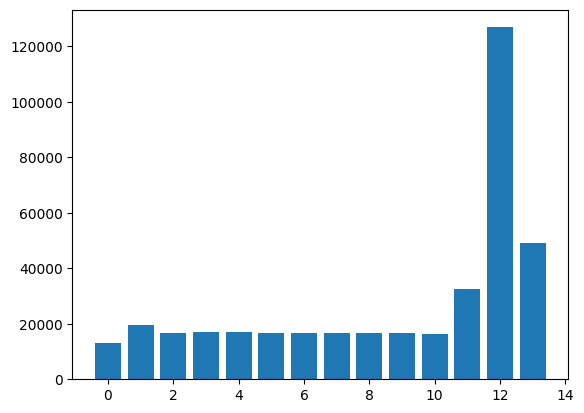

In [13]:
#  train_data_bow에서 등장하는 token의 분포를 출력해보세요.
digits, count = np.unique(train_data_bow, return_counts=True)

plt.bar(digits, count)

### 문제 8. train_answer_bow에서 등장하는 token의 분포를 출력해보세요.

<BarContainer object of 13 artists>

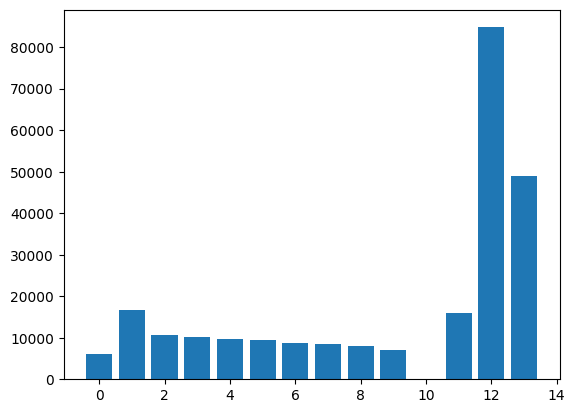

In [14]:
#  train_answer_bow에서 등장하는 token의 분포를 출력해보세요.

digits, count = np.unique(train_answer_bow, return_counts=True)

plt.bar(digits, count)

## Step 4. Seq2Seq용 입출력 보정

### 문제 9. train/test_answer_bow를 한쪽씩 당겨서 decoder에 주입시킬 데이터를 생성해보세요.

In [15]:
# train/test_answer_bow를 한쪽씩 당겨서 decoder에 주입시킬 데이터를 생성해보세요.

train_shift_answer_bow = np.concatenate([np.ones((train_answer_bow.shape[0], 1)) * vocab['PAD'], train_answer_bow[...,:-1]], axis = 1)

test_shift_answer_bow = np.concatenate([np.ones((test_answer_bow.shape[0], 1)) * vocab['PAD'], test_answer_bow[...,:-1]], axis = 1)

In [16]:
train_answer_bow[...,:-1][0]

array([ 5,  8, 13, 12], dtype=int32)

In [17]:
train_answer_bow[0]

array([ 5,  8, 13, 12, 12], dtype=int32)

In [18]:
print(train_shift_answer_bow.shape, test_shift_answer_bow.shape)

(49000, 5) (1000, 5)


### 문제 10. 정답으로 처리될 train/test_answer_bow를 onehot 인코딩으로 바꾸기

In [19]:
# train/test_anser_bow를 onehot으로 바꾸는 코드를 작성하세요

train_answer_onehot = tf.keras.utils.to_categorical(train_answer_bow, len(vocab))
test_answer_onehot = tf.keras.utils.to_categorical(test_answer_bow, len(vocab))

print(train_answer_onehot.shape, test_answer_onehot.shape)

(49000, 5, 14) (1000, 5, 14)


### 문제 11. data_bow, anser_bow, shift_answer_bow, onehot를 1개씩 출력해보세요.

In [20]:
# data_bow, shift_answer_bow, onehot, answer_bow등을 1개씩 출력해보세요
print(train_data_bow[0], train_data_bow.shape)

print(train_answer_bow[0], train_answer_bow.shape)
print(train_shift_answer_bow[0], train_shift_answer_bow.shape)
print(train_answer_onehot[0], train_answer_onehot.shape)

[12 12 12  5  3 10  5 13] (49000, 8)
[ 5  8 13 12 12] (49000, 5)
[12.  5.  8. 13. 12.] (49000, 5)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]] (49000, 5, 14)


### 문제 12. onehot를 readable하게 바꿔주는 함수를 작성해보세요.

In [21]:
# onehot을 readable하게 바꿔주는 함수를 작성해보세요. (단, EOS는 .으로 PAD는 공백으로 전환)

def onehot2text(onehot):
    return "".join(invocab[step.argmax()] for step in onehot).replace('EOS', '.').replace('PAD', '')

onehot2text(train_answer_onehot[0])

'58.'

In [22]:
train_text[0]

'53 + 5'

### 문제 13. bow를 readable하게 바꿔주는 함수를 작성해보세요.

In [23]:
# bow를 readable하게 바꿔주는 함수를 작성해보세요. (단, EOS는 .으로 PAD는 _으로 전환)

def bow2text(bow):
    return "".join(invocab[step] for step in bow).replace('EOS', '.').replace('PAD', '')

print(bow2text(train_data_bow[0]))
print(bow2text(train_shift_answer_bow[0]))
print(bow2text(train_answer_bow[0]))

53+5.
58.
58.


## Step 5. Seq2Seq 모델링

### 문제 14. Seq2Seq 모델 구축

In [24]:
# seq2seq 모델을 구축하고 학습모델, encoder, decoder를 획득하세요

from keras.layers import Input, Embedding, GRU
from keras.models import Model

# 모델, 인코더, 디코더 반환
def seq2seq(): 
    inputs_x_bow = Input(shape = (8,))

    # encoder
    embedding = Embedding(len(vocab), output_dim = 5) # 압축
    x = embedding(inputs_x_bow)
    z = GRU(units=16)(x) # z (context)

    # decoder
    inputs_y_bow = Input(shape=(5, ))
    y = embedding(inputs_y_bow)
    gru = GRU(units = 16, return_sequences=True)
    
    y = gru(y, initial_state=z)

    softmax = Dense(units=len(vocab), activation = 'softmax')

    y = softmax(y)
    
    model = Model([inputs_x_bow, inputs_y_bow], y)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    encoder = Model(inputs_x_bow, z)
    
    inputs_y_dec = Input(shape=(1,))
    y2 = embedding(inputs_y_dec)

    inputs_z = Input(shape = (16, ))
    h2 = gru(y2, initial_state=inputs_z)
    y2 = softmax(h2)

    decoder = Model([inputs_y_dec, inputs_z], [y2, h2])
    
    return model, encoder, decoder
    



### 문제 15. 학습 모델을 생성하고 summary를 출력하세요. 

In [25]:
# 학습 모델을 생성하고 summary를 출력하세요.
model, encoder, decoder = seq2seq()
model.summary()

2023-10-24 00:14:35.008888: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-24 00:14:35.008909: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-10-24 00:14:35.008916: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-10-24 00:14:35.008946: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-24 00:14:35.008960: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 embedding (Embedding)       multiple                     70        ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 gru (GRU)                   (None, 16)                   1104      ['embedding[0][0]']       

### 문제 16. encoder, decoder에 대한 summary를 출력하세요.

In [26]:
 # encoder, decoder에 대한 summary를 출력하세요.

print(encoder.summary())
print(decoder.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 embedding (Embedding)       multiple                  70        
                                                                 
 gru (GRU)                   (None, 16)                1104      
                                                                 
Total params: 1174 (4.59 KB)
Trainable params: 1174 (4.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         [] 

### 문제 17. 학습모델을 학습해보세요.

In [27]:
# 학습모델을 학습해보세요.
hist = model.fit([train_data_bow, train_shift_answer_bow], train_answer_onehot,
          validation_data = ([test_data_bow, test_shift_answer_bow], test_answer_onehot), verbose = 1, epochs = 60
        )

Epoch 1/60


2023-10-24 00:14:37.565497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-24 00:14:38.356791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-24 00:14:38.935108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-24 00:14:40.459990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-24 00:14:41.416044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1532/1532 [==============================] - ETA: 0s - loss: 1.2057 - accuracy: 0.5952

2023-10-24 00:16:12.171212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-24 00:16:12.463908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-24 00:16:12.936238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1532/1532 [==============================] - 100s 61ms/step - loss: 1.2057 - accuracy: 0.5952 - val_loss: 0.9573 - val_accuracy: 0.6626
Epoch 2/60
1532/1532 [==============================] - 88s 58ms/step - loss: 0.9112 - accuracy: 0.6659 - val_loss: 0.8686 - val_accuracy: 0.6730
Epoch 3/60
1532/1532 [==============================] - 91s 59ms/step - loss: 0.8393 - accuracy: 0.6894 - val_loss: 0.8029 - val_accuracy: 0.7070
Epoch 4/60
1532/1532 [==============================] - 91s 59ms/step - loss: 0.7656 - accuracy: 0.7252 - val_loss: 0.7258 - val_accuracy: 0.7458
Epoch 5/60
1532/1532 [==============================] - 92s 60ms/step - loss: 0.6895 - accuracy: 0.7529 - val_loss: 0.6549 - val_accuracy: 0.7676
Epoch 6/60
1532/1532 [==============================] - 91s 59ms/step - loss: 0.6309 - accuracy: 0.7739 - val_loss: 0.6101 - val_accuracy: 0.7848
Epoch 7/60
1532/1532 [==============================] - 92s 60ms/step - loss: 0.5886 - accuracy: 0.7898 - val_loss: 0.5763 - val_accur

### 문제 18. 학습 진행 사항을 plt으로 출력하세요.

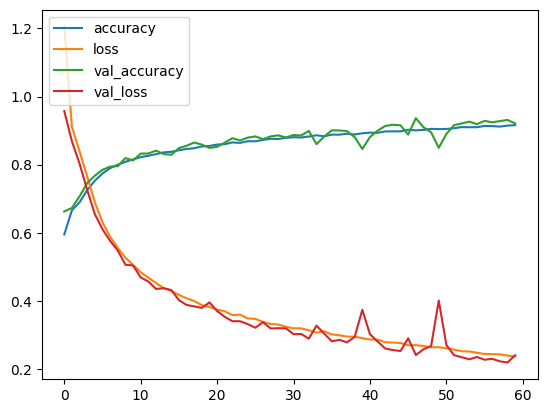

In [28]:
# hist의 accuracy와 loss를 plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['accuracy'], label = 'accuracy')
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'upper left')
plt.show()

## Step 6. 모델 결과 확인

### 문제 19. plain2bow를 이용하여 encoder에 bow를 주입하고 z를 받아보세요.

In [29]:
# plain2bow를 이용하여 encoder에 bow를 주입하고 z를 받아보세요.
bow = plain2bow("22 + 22", vocab)
bow = tf.keras.preprocessing.sequence.pad_sequences(bow[np.newaxis,:], value = vocab['PAD'], maxlen=8)
z = encoder(bow)

print(bow.shape, bow)


(1, 8) [[12 12  2  2 10  2  2 13]]


In [30]:
z

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[ 0.48876566,  0.96227694, -0.97874445, -0.77893126,  0.9974153 ,
         0.02695178,  0.3258279 , -0.42176116,  0.9711058 ,  0.99717456,
        -0.9994585 ,  0.93734425,  0.4893149 ,  0.99893004,  0.9990314 ,
         0.71410066]], dtype=float32)>

### 문제 20. z와 PAD를 이용하여 첫번째 decoder 값을 획득해보세요.

In [31]:
# z와 PAD를 이용하여 첫번째 decoder 값을 획득해보세요.
init = np.array([vocab['PAD']])

first_pred, first_z = decoder([init, z])
print(first_z)

tf.Tensor(
[[[ 0.99454033  0.9960951  -0.99957156  0.9879606   0.99993086
    0.8481404   0.99878865 -0.99763215  0.99988556 -0.997255
    0.9768392   0.23171419  0.9998669   0.78078526  0.9990314
    0.99865556]]], shape=(1, 1, 16), dtype=float32)


In [32]:
print(first_pred)

tf.Tensor(
[[[8.3518016e-15 3.5278867e-15 1.8296880e-08 2.2510940e-02 9.6804976e-01
   9.4301766e-03 3.6541715e-06 2.7673138e-06 3.5452672e-07 2.3242903e-06
   8.7651223e-12 1.0785830e-15 7.5760907e-21 4.1341810e-19]]], shape=(1, 1, 14), dtype=float32)


### 문제 21. first_pred에 값이 가장 큰 index를 이용하여 문자로 decoding 하세요.

In [33]:
# first_pred에 값이 가장 큰 index를 이용하여 문자로 decoding 하세요.
first_pred.numpy().argmax()

4

### 문제 22. first_z와 first_pred를 이용해서 second_pred를 획득하고 문자로 decoding 해보세요.

In [34]:
# first_z와 first_pred를 이용해서 second_pred를 획득하고 문자로 decoding 해보세요.

second_pred, second_z = decoder([np.array([first_pred.numpy().argmax()]), first_z[0]])

In [39]:
print(second_pred)

tf.Tensor(
[[[3.0030898e-04 4.7731013e-03 5.6006871e-02 1.9445442e-01 3.4529313e-01
   2.6572028e-01 1.1453254e-01 1.8166468e-02 7.2413025e-04 2.8795836e-05
   5.6097762e-11 2.1627264e-09 1.6786046e-17 7.0116322e-09]]], shape=(1, 1, 14), dtype=float32)


In [40]:
second_z

<tf.Tensor: shape=(1, 1, 16), dtype=float32, numpy=
array([[[ 0.98535246,  0.81160074, -0.29348043, -0.9999995 ,
          0.9997189 ,  0.9999885 ,  0.99999887, -0.99987787,
         -0.38730136, -0.99999994,  0.98775   ,  0.05478399,
          0.7821175 , -0.8502182 ,  0.9992442 , -0.99994856]]],
      dtype=float32)>

In [41]:
invocab[second_pred.numpy().argmax()]

'4'

In [42]:
third_pred, third_z = decoder([np.array([second_pred.numpy().argmax()]), second_z[0]])

In [43]:
invocab[third_pred.numpy().argmax()]

'EOS'

### 문제 23. 입력 text가 주어지면 bow로 바꾼뒤 pad가 나올 때까지 문자를 decoding하는 함수를 만드세요.


In [44]:
# z와 pad가 주어지면 pad가 나올 때까지 문자를 decoding하는 함수를 만드세요.

def decoding(text):
    bow = plain2bow(text, vocab)
    bow = tf.keras.preprocessing.sequence.pad_sequences(bow[np.newaxis, :], value=vocab['PAD'], maxlen=8)

    z = encoder(bow)
    word_vec = np.array([vocab['PAD']])

    res = []
    while True:
        word_vec, z = decoder([word_vec, z])
        word = invocab[word_vec.numpy().argmax()]

        if word in ['EOS', 'PAD']: break
        res.append(word)
        word_vec = np.array([word_vec.numpy().argmax()])
        z = z[0]

    answer = ''.join(res)
    print(f'{text} = {answer}')

    return answer
        



### 문제 24. decoding으로 몇가지 산술 연산을 테스트해보세요.

In [49]:
# decoding으로 몇가지 산술 연산을 테스트해보세요

decoding("12 + 12")

12 + 12 = 23


'23'

### 문제 25. 모델을 평가해보세요.

In [37]:
# 모델을 평가해보세요.

model.evaluate([test_data_bow, test_shift_answer_bow], test_answer_onehot, verbose = 1)

32/32 [==============================] - 1s 44ms/step - loss: 0.2405 - accuracy: 0.9212


[0.24052251875400543, 0.9211999773979187]

## Step 7. 모델 저장 및 로드, 다운

### 문제 26. 모델을 저장하세요.

In [45]:
# 모델을 저장하는 코드를 작성하세요.
model.save('./part3_ch01.h5')
encoder.save('./part3_ch01_encoder.h5')
decoder.save('./part3_ch01_decoder.h5')

### 문제 27. 모델 파일을 새로운 모델에 로드하세요.

In [46]:
# 모델을 로드하는 코드를 작성하세요.
new_model = tf.keras.models.load_model('./part3_ch01.h5')

### 문제 28. 로드한 모델을 test 데이터로 평가해보세요.


In [48]:
# 로드한 모델을 test 데이터로 평가해보세요.
new_model.evaluate([test_data_bow, test_shift_answer_bow], test_answer_onehot, verbose = 1)

2023-10-24 01:49:14.745610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-24 01:49:15.048872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-24 01:49:15.541671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 4s 66ms/step - loss: 0.2405 - accuracy: 0.9212


[0.24052251875400543, 0.9211999773979187]

### 문제 29. 모델을 내 컴퓨터에 저장해보세요

In [ ]:
# 모델을 내 컴퓨터에 저장해보세요.